In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 我们最多生成 20 阶特征
n_train, n_test = 100, 100  # 训练集和测试集样本数
true_w = torch.zeros(max_degree)  # 初始化权重，全为 0
true_w[0:4] = torch.tensor([5, 1.2, -3.4, 5.6])  # 设置前三项为非0（3阶多项式）

features = torch.randn((n_train + n_test, 1))  # 从标准正态分布采样输入
poly_features = torch.pow(features, torch.arange(0, max_degree).reshape(1, -1).float())
labels = torch.matmul(poly_features, true_w) + torch.normal(0, 0.1, size=(n_train + n_test,))

In [3]:
def evaluate_loss(net, data_iter, loss):
    metric = 0
    for X, y in data_iter:
        y_hat = net(X)
        metric += loss(y_hat, y).item()
    return metric / len(data_iter)

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, nn.Module):
        net.train()
    metric = d2l.Accumulator(3)  # [损失总和, 正确预测数, 样本数]
    for X, y in train_iter:
        # (a) 前向传播: 每个样本的 loss
        l_values = loss(net(X), y)  # shape: [batch_size]
        # (b) 取平均做反向传播
        l_mean = l_values.mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l_mean.backward()
            updater.step()
        else:
            l_mean.backward()
            updater(X.shape[0])
        # (c) 记录: 批量的总损失 + 正确数 + 样本数
        metric.add(float(l_values.sum()), accuracy(net(X), y), y.numel())
    # 返回整个 epoch 的平均损失和平均准确率
    return metric[0] / metric[2], metric[1] / metric[2]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=1e-4)
    train_ls, test_ls = [], []
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        train_ls.append(evaluate_loss(net, train_iter, loss))
        test_ls.append(evaluate_loss(net, test_iter, loss))
    print('final loss:', train_ls[-1], test_ls[-1])
    d2l.plot(list(range(1, num_epochs + 1)), [train_ls, test_ls],
             xlabel='epoch', ylabel='loss',
             legend=['train', 'test'], yscale='log')


final loss: 231.13154640197754 308.3549643516541


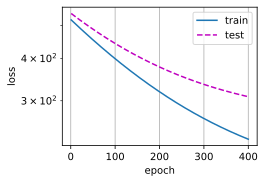

In [4]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

final loss: 9.586546850204467 11.115218305587769


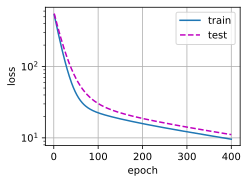

In [5]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

final loss: 27.944038915634156 40.329459118843076


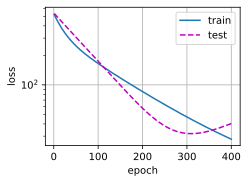

In [6]:
# 多项式特征标准化
poly_features = (poly_features - poly_features.mean(dim=0)) / (poly_features.std(dim=0) + 1e-8)


# 再训练
train(poly_features[:n_train, :20], poly_features[n_train:, :20], labels[:n_train], labels[n_train:])